# CX 4230, Spring 2016 [13]: Infection modeling via ODEs

## (Sample solutions)

So far you've looked at two approaches to conceptually modeling and simulating an SIR (susceptible-infected-recovered) system:

* Celluar automata: discrete states (binary S, I, and R), discrete time, discrete space.
* Markov chains: continuous states (probabilistic S, I, and R), discrete time or "no time" (steady-state), discrete space.

In this notebook, you'll consider a third approach in which all of the state, time, and space variables are treated as continuous. The usual conceptual modeling language for continuous variables is the language of _differential equations_.

## Setup

Run these code cells to get started.

In [1]:
# Our usual multidimensional array tools
import numpy as np
import scipy as sp
import scipy.sparse
from scipy.integrate import odeint

In [2]:
 # Core plotting support
import matplotlib.pyplot as plt
%matplotlib inline

## Conceptual model

There are several possible conceptual models. Recall the one discussed in class:

* Model three population types as _fractions_ of the total population that vary continuously in time: $S \equiv S(t)$ for suscetible people, $I \equiv I(t)$ for infected people, and $R \equiv R(t)$ for recovered people.
* Ignore the spatial dimension and assume the subpopulations are _well-mixed_, i.e., everyone is connected to everyone else.
* Let $\tau$ be a rate of infection spread, having inverse-time units.
* Let $\rho$ be a rate of recovery, also having inverse-time units.

From these starting assumptions, we developed a conceptual model of the system as a system of _ordinary differential equations_ (ODEs):

$$
\begin{eqnarray}
  \dfrac{dI(t)}{dt} & = & \tau I(t) S(t) - \rho I(t) \\
  \dfrac{dS(t)}{dt} & = & -\tau I(t) S(t) \\
  \dfrac{dR(t)}{dt} & = & \rho I(t)
\end{eqnarray}
$$

> Recall that the $\rho I(t)$ term measures the fraction of the infected population that recovers per unit time. We also discussed a variation on this term in class, which expresses recovery using a _delay_ term, $I(t-k)$; such a term results in a [_delay differential equation_](https://en.wikipedia.org/wiki/Delay_differential_equation).

In [3]:
TAU = 0.1
RHO = 0.5

## Simulator

To build a "simulator" for this system of ODEs, we can use a black-box ODE solver. Let's use Scipy's [`odeint()`](http://docs.scipy.org/doc/scipy-0.16.1/reference/generated/scipy.integrate.odeint.html#scipy.integrate.odeint).

Recall that a generic ODE solver expects to be given a system of the form,

$$
  \dfrac{d\vec{y}(t)}{dt} = f(t, \vec{y}),
$$

where $\vec{y}(t)$ is the vector whose $m$ components are the continuous state variables of the system,

$$
\begin{eqnarray}
  \vec{y}(t)
    & \equiv & \left(\begin{array}{c}
                 y_0(t) \\
                 y_1(t) \\
                 \vdots \\
                 y_{m-1}(t)
               \end{array}\right),
\end{eqnarray}
$$

and $\vec{f}(t, \vec{y})$ is a vector function having $m$ components that depend on the time $t$ and the state variable (components) of $\vec{y}$:

$$
\begin{eqnarray}
  \vec{f}(t, \vec{y})
    & \equiv & \left(\begin{array}{c}
                 f_0(t, \vec{y}) \\
                 f_1(t, \vec{y}) \\
                 \vdots \\
                 f_{m-1}(t, \vec{y})
               \end{array}\right).
\end{eqnarray}
$$

**Exercise.** For the SIR-ODE model above, define $\vec{y}$ and $\vec{f}(t, \vec{y})$.

> Answer: Let $m \equiv 3$ and
>
> $$\begin{eqnarray}
   y_0(t) & \equiv & I(t) \\
   y_1(t) & \equiv & S(t) \\
   y_2(t) & \equiv & R(t) \\
   f_0(t, \vec{y}) & \equiv & \tau y_0(t) y_1(t) - \rho y_0(t) \\
   f_1(t, \vec{y}) & \equiv & -\tau y_0(t) y_1(t) \\
   f_2(t, \vec{y}) & \equiv & \rho y_0(t)
 \end{eqnarray}.$$

**Exercise.** Define a Python function, `f_sirode(y[:], t)`, that implements the (mathematical) vector function $\vec{f}(t, \vec{y})$.

In [4]:
def f_sirode (y, t, tau=TAU, rho=RHO):
    assert type (y) is np.ndarray
    assert type (t) is float
    f = np.zeros (y.shape)
    # @YOUSE: Compute `f[:]`
    #assert (False)
    f[0] = tau * y[0] * y[1] - rho * y[0]
    f[1] = -tau * y[0] * y[1]
    f[2] = rho * y[0]
    return f

In [5]:
def isim (tau=TAU, rho=RHO, i0=0.01, t_max=10.0, n_t=100):
    assert t_max > 0.0
    t_all = np.linspace (0.0, t_max, n_t)
    y0 = np.array ([i0, 1.0-i0, 0.0])
    y_t = odeint (f_sirode, y0, t_all, args=(tau, rho))
    plt.plot (t_all, y_t[:, 0], 'r', t_all, y_t[:, 1], 'y', t_all, y_t[:, 2], 'b')
    print ("[I, S, R](t=%g) ~= [%g, %g, %g]" \
           % (t_all[-1], y_t[-1, 0], y_t[-1, 1], y_t[-1, 2]))

[I, S, R](t=10) ~= [0.00673795, 0, 0.993262]


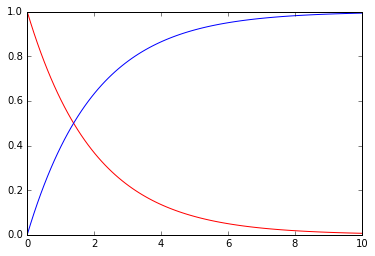

In [6]:
# Initial conditions
I0 = 0.01
S0 = 1.0 - I0
R0 = 0.0
y0 = np.array ([I0, S0, R0])

from ipywidgets import interact

interact (isim
          , tau=(0.0, 2.0, 0.01)
          , rho=(0.0, 2.0, 0.01)
          , i0=(0.0, 1.0, 0.01)
          , t_max=(0.0, 100.0, 10.0)
          , n_t=(1, 500, 50)
         )

**Exercise.** Recall the results from the probabilistic Markov chain model in 1-D with 3 cells, a conditional probability of infection given exposure of 0.2, and a recovery time of $k=2$ days. In the steady-state, you found both by calculation and cellular automaton simulation that

* the probability of just 1 recovered cell is 0.4096;
* the probability of 2 recovered cells is 0.4608;
* and the probability of 3 recovered cells is 0.1296.

Thus, the expected fraction of the population in the recovered state in the steady-state limit is $0.4096\times\frac{1}{3} + 0.4608\times\frac{2}{3} + 0.1296\times\frac{3}{3} \approx 0.420$.

Consider the ODE model where $I(0) \approx \frac{1}{3}$. Find values for $\tau$ and $\rho$ such that the fraction of the population in the recovered state approximately matches that of the Markov chain model.

> Answer: In general, there are many possibilities. One is $(\tau=0.2, \rho=0.55)$. Another is $(\tau=0.6, \rho=1.74)$. You can find these by trial-and-error, or you could use a _root-finder_ to solve for parameter values that make $R(t) - 0.42 = 0$.